In [1]:
import os
import json
import jax
from time import time
from jax import config
import numpy as np
import jax.numpy as jnp
import flax.linen as nn
from termcolor import colored

from src.utils import *
from src.boundary_conditions import *
from src.models import BGKSim, KBCSim
from src.lattice import LatticeD2Q9

# Use 8 CPU devices
# os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=8'
jax.config.update('jax_enable_x64', True)


In [ ]:
class Cylinder(BGKSim):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def set_boundary_conditions(self):
        # Define the cylinder surface
        coord = np.array([(i, j) for i in range(self.nx) for j in range(self.ny)])
        xx, yy = coord[:, 0], coord[:, 1]
        cx, cy = 2.*_diam, 2.*_diam
        cylinder = (xx - cx)**2 + (yy-cy)**2 <= (_diam/2.)**2
        cylinder = coord[cylinder]
        implicit_distance = np.reshape((xx - cx)**2 + (yy-cy)**2 - (_diam/2.)**2, (self.nx, self.ny))
        self.BCs.append(InterpolatedBounceBackBouzidi(tuple(cylinder.T), implicit_distance, self.gridInfo, self.precisionPolicy))

        # Outflow BC
        outlet = self.boundingBoxIndices['right']
        rho_outlet = np.ones((outlet.shape[0], 1), dtype=self.precisionPolicy.compute_dtype)
        self.BCs.append(ExtrapolationOutflow(tuple(outlet.T), self.gridInfo, self.precisionPolicy))
        # self.BCs.append(ZouHe(tuple(outlet.T), self.gridInfo, self.precisionPolicy, 'pressure', rho_outlet))

        # Inlet BC
        inlet = self.boundingBoxIndices['left']
        rho_inlet = np.ones((inlet.shape[0], 1), dtype=self.precisionPolicy.compute_dtype)
        vel_inlet = np.zeros(inlet.shape, dtype=self.precisionPolicy.compute_dtype)
        yy_inlet = yy.reshape(self.nx, self.ny)[tuple(inlet.T)]
        vel_inlet[:, 0] = poiseuille_profile(yy_inlet,
                                             yy_inlet.min(),
                                             yy_inlet.max()-yy_inlet.min(), 3.0 / 2.0 * _prescribed_vel)
        self.BCs.append(Regularized(tuple(inlet.T), self.gridInfo, self.precisionPolicy, 'velocity', vel_inlet))

        # No-slip BC for top and bottom
        wall = np.concatenate([self.boundingBoxIndices['top'], self.boundingBoxIndices['bottom']])
        vel_wall = np.zeros(wall.shape, dtype=self.precisionPolicy.compute_dtype)
        self.BCs.append(Regularized(tuple(wall.T), self.gridInfo, self.precisionPolicy, 'velocity', vel_wall))

    def output_data(self, **kwargs):
        self.saved_data.append(kwargs)
        # 1:-1 to remove boundary voxels (not needed for visualization when using bounce-back)
    
    def get_force(self):
        pass

# Helper function to specify a parabolic poiseuille profile
poiseuille_profile  = lambda x,x0,d,umax: np.maximum(0.,4.*umax/(d**2)*((x-x0)*d-(x-x0)**2))

In [ ]:
from flax import linen as nn

class ConvBlock(nn.Module):
  """Defines a convolutional block with activation and normalization."""
  features: int
  kernel_size: int = (3,3)
  strides: int = 1

  @nn.compact
  def __call__(self, inputs):
    x = nn.Conv(self.features, kernel_size=self.kernel_size, strides=self.strides, padding='SAME')(inputs)
    x = nn.BatchNorm(use_running_average=True)(x)
    x = nn.relu(x)
    return x

class DownBlock(nn.Module):
  """Downsamples feature maps through convolutions and pooling."""
  features: int
  pool_factor: int = 2

  @nn.compact
  def __call__(self, x):
    x = ConvBlock(self.features)(x)
    x = ConvBlock(self.features)(x)
    return x

class UpBlock(nn.Module):
  """Upsamples feature maps and concatenates with features from the contracting path."""
  features: int
  up_factor: int = 2

  @nn.compact
  def __call__(self, x):
    x = ConvBlock(self.features)(x)
    x = ConvBlock(self.features)(x)
    x = nn.ConvTranspose(self.features, kernel_size=(2, 2), strides=self.up_factor, padding='VALID')(x)
    return x

class UNet(nn.Module):
  """UNet architecture with contracting and expanding paths."""
  features_start: int = 64

  @nn.compact
  def __call__(self, x):
    input_shape = x.shape
    # Contracting path
    down1 = DownBlock(self.features_start * 2)(x)
    down1_max_pooled = nn.max_pool(down1, window_shape=(2, 2), strides=(2, 2))
    down2 = DownBlock(self.features_start * 4)(down1_max_pooled)
    down2_max_pooled = nn.max_pool(down2, window_shape=(2, 2), strides=(2, 2))
    down3 = DownBlock(self.features_start * 8)(down2_max_pooled)
    down3_max_pooled = nn.max_pool(down3, window_shape=(2, 2), strides=(2, 2))
    down4 = DownBlock(self.features_start * 16)(down3_max_pooled)
    down4_max_pooled = nn.max_pool(down4, window_shape=(2, 2), strides=(2, 2))
    
    # Expanding path with concatenation
    up1 = UpBlock(self.features_start * 16)(down4_max_pooled)
    down4_sliced = jax.lax.slice(down4, (4, 4, 0),(down4.shape[0]-4, down4.shape[1]-4, down4.shape[2]))
    up1_concatenated = jax.lax.concatenate([down4_sliced, up1], dimension=2)
    up2 = UpBlock(self.features_start * 4)(up1_concatenated)
    down3_sliced = jax.lax.slice(down3, (4, 4, 0), (down3.shape[0]-4, down3.shape[1]-4, down3.shape[2]))
    up2_concatenated = jax.lax.concatenate([down3_sliced, up2], dimension=2)
    up3 = UpBlock(self.features_start * 2)(up2_concatenated)
    print(up3.shape)
    return up3
  
class SimpleNet(nn.Module):
    features: int = 32
    kernel_size: int = (5, 5)
    strides: int = 1
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(self.features, kernel_size=self.kernel_size, strides=self.strides, padding='SAME')(x)
        x = nn.leaky_relu(x)
        x = nn.Conv(self.features, kernel_size=self.kernel_size, strides=self.strides, padding='SAME')(x)
        x = nn.leaky_relu(x)
        x = nn.Conv(self.features, kernel_size=self.kernel_size, strides=self.strides, padding='SAME')(x)
        x = nn.leaky_relu(x)
        x = nn.Conv(2, kernel_size=self.kernel_size, strides=self.strides, padding='SAME')(x)
        return x
        

In [ ]:
my_unet = SimpleNet()
print(my_unet.tabulate(jax.random.key(0), jnp.ones((64,32,3)),
                   compute_flops=True, compute_vjp_flops=True)) # check parameters, should be 55,298 in total

In [ ]:
def generate_sim_dataaset(diam, timestep_offset, timestep_stride, timestep_end):
    global _diam
    global _prescribed_vel
    _diam = diam
    precision = 'f64/f64'
    # diam_list = [10, 20, 30, 40, 60, 80]
    scale_factor = 80 / diam
    prescribed_vel = 0.003 * scale_factor
    _prescribed_vel = prescribed_vel
    lattice = LatticeD2Q9(precision)

    nx = int(22*diam)
    ny = int(4.1*diam)

    Re = 100.0
    visc = prescribed_vel * diam / Re
    omega = 1.0 / (3. * visc + 0.5)
    
    os.system('rm -rf ./*.vtk && rm -rf ./*.png')

    kwargs = {
        'lattice': lattice,
        'omega': omega,
        'nx': nx,
        'ny': ny,
        'nz': 0,
        'precision': precision,
        'io_rate': timestep_stride,
        'return_fpost': True    # Need to retain fpost-collision for computation of lift and drag
    }
    # characteristic time
    tc = prescribed_vel/diam
    niter_max = timestep_end
    if timestep_end < int(100//tc):
        print(colored("WARNING: timestep_end is too small, Karman flow may not appear", "red"))
    sim = Cylinder(**kwargs)
    sim.run(niter_max)
    return sim.saved_data

In [ ]:
generated_data = generate_sim_dataaset(10, 0, 500, 20000)

In [3]:
from tqdm import tqdm
import numpy as np

def read_data():
    res_data = []
    total_batch = 1
    for i in tqdm(range(total_batch)):
        loaded_data = jnp.load('./data/ref_data_diam_80_seq_{}.npy'.format(i))
        res_data.append(loaded_data)
    return jnp.concatenate(res_data, axis=0)

def read_data_and_downsample():
    res_data = []
    total_batch = 10
    for i in tqdm(range(total_batch)):
        loaded_data = np.load('./data/ref_data_diam_80_seq_{}.npy'.format(i))
        downsampled_list = [downsample_field(field, 8) for field in loaded_data]
        res_data.append(downsampled_list)
    return np.concatenate(res_data, axis=0)

In [4]:
output_data = read_data()

100%|██████████| 1/1 [00:03<00:00,  3.36s/it]


In [5]:
output_data[0]

Array([[[-5.79231617e-05,  1.29113880e-05],
        [ 5.48775356e-05,  0.00000000e+00],
        [ 1.09418399e-04,  0.00000000e+00],
        ...,
        [ 1.09418399e-04,  0.00000000e+00],
        [ 5.48775356e-05,  0.00000000e+00],
        [-4.99685732e-05, -1.85080848e-05]],

       [[-1.38035543e-17,  0.00000000e+00],
        [ 3.75266060e-05, -4.36268517e-05],
        [ 1.01912962e-04, -1.85456908e-05],
        ...,
        [ 1.00890235e-04,  1.93246992e-05],
        [ 4.39215389e-05,  3.27327658e-05],
        [ 0.00000000e+00,  0.00000000e+00]],

       [[ 0.00000000e+00,  0.00000000e+00],
        [ 3.30232786e-05,  1.34797579e-05],
        [ 1.13430050e-04, -1.54233424e-07],
        ...,
        [ 1.13657093e-04,  3.82971936e-08],
        [ 3.46938178e-05, -6.46296743e-06],
        [ 0.00000000e+00,  0.00000000e+00]],

       ...,

       [[ 0.00000000e+00,  0.00000000e+00],
        [ 2.99285022e-04, -7.16855591e-07],
        [ 6.20223212e-04, -1.18489453e-06],
        ...,
     

In [6]:
import matplotlib.pyplot as plt
def visualize_data(data, imgs=20):
    fig, axs = plt.subplots(1, imgs)
    for i in range(imgs):
        img = (data[i*(data.shape[1]//imgs)] + 0.2)/0.27
        img = np.concatenate((img, np.zeros((img.shape[0], img.shape[1], 1))), axis=2)
        print(img.shape)
        axs[i].imshow(img)

(1760, 328, 3)
(1760, 328, 3)
(1760, 328, 3)
(1760, 328, 3)
(1760, 328, 3)
(1760, 328, 3)
(1760, 328, 3)
(1760, 328, 3)
(1760, 328, 3)
(1760, 328, 3)


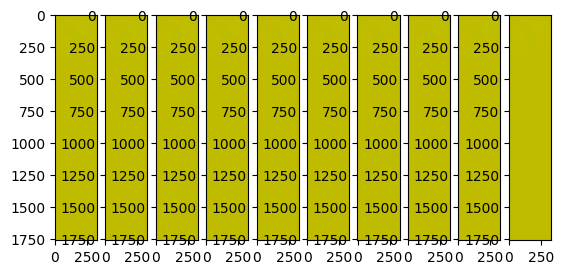

In [7]:
visualize_data(output_data, 10)